In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import random
from scipy.ndimage import rotate, zoom
from sklearn.preprocessing import PowerTransformer
import pickle
from tqdm import tqdm
from multiprocessing import Pool
import gc

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from keras import models, layers, losses, optimizers, Model
from keras.utils import plot_model

2023-11-04 22:40:21.691288: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-04 22:40:21.691323: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-04 22:40:21.691356: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gc.collect()

0

In [3]:
def pickle_pi_set(pi):
    pi_set = []
    mat_i = loadmat(f"mats/data-science-P{pi+1}.mat")
    coord_to_col = mat_i["meta"][0][0][8]
    data = mat_i["data"]
    info = mat_i["info"][0]

    yeojohnTr = PowerTransformer(standardize=True)
    
    for i in tqdm(range(359), desc=str(pi)):
        datum = data[i][0][0]

        scan = np.zeros((23, 61, 51))
        for x in range(51):
            for y in range(61):
                for z in range(23):
                    scan[z, y, x] = datum[coord_to_col[x, y, z] - 1]


        mask = scan != mode(scan.flat).mode

        scan[mask] = yeojohnTr.fit_transform(scan[mask].reshape((-1, 1))).reshape((-1, ))

        scan[mask] -= scan[mask].mean()
        scan[mask] /= scan[mask].std()

        n = 3
        mask_std = scan[mask].std()
        scan[scan > n * mask_std] = n * mask_std
        scan[scan < -n * mask_std] = -n * mask_std
        scan[scan == mode(scan.flat).mode] = scan[mask].min()

        scan[scan < 0] /= abs(scan.min())
        scan[scan > 0] /= scan.max()
        pi_set.append((scan, info[i][2][0]))

    with open(f"pickles/{pi}.pkl", "wb") as f:
        pickle.dump(pi_set, f)
    
        

In [4]:
def pickle_set():
    if not os.path.exists("pickles"):
        os.mkdir("pickles")
    Pool(processes=5).map(pickle_pi_set, range(9))

# pickle_set()

In [5]:
NUM_CLASSES = 5

pickles = [pickle.load(open(f"pickles/{i}.pkl", "rb")) for i in range(5)]
targets = set([pickles[0][i][1] for i in range(len(pickles[0]))])

targets = list(targets)[:NUM_CLASSES]
targets = {k: v for k, v in zip(targets, [[1 if i == j else 0 for i in range(NUM_CLASSES)] for j in range(len(targets))])}

pickles = [item for sublist in pickles for item in sublist if item[1] in targets]
print(len(pickles))

split = int(0.8 * len(pickles))
trains, tests = pickles[:split], pickles[split:]

train_x = np.array([train[0] for train in trains])
train_y = np.array([train[1] for train in trains])

test_x = [test[0] for test in tests]
test_y = [test[1] for test in tests]

del pickles, trains, tests

150


In [6]:
def get_sample(i, train=True):
    i = random.randint(0, len(train_x) - 1)

    x, y = ((train_x, train_y) if train else (test_x, test_y))
    scan, target = x[i], y[i]
    
    # scan = rotate(scan, random.randint(-5, 5), axes=(1, 2), order=1, reshape=False)

    scan = np.pad(scan, ((0, 0), (2, 1), (7, 6)), constant_values=-1)
    scan = np.expand_dims(scan, -1)
    
    target = targets[target]

    return scan, target

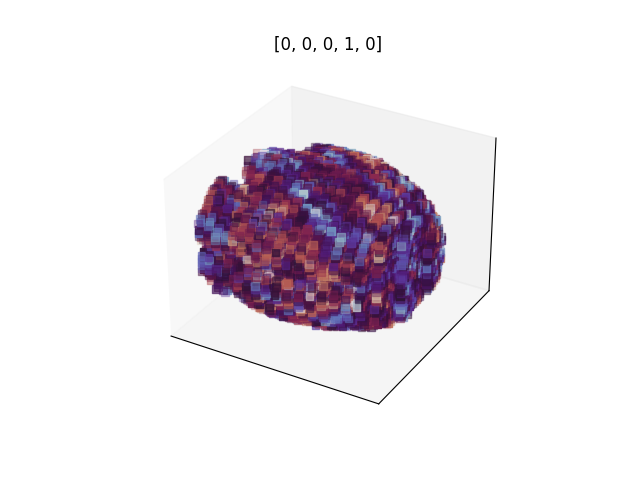

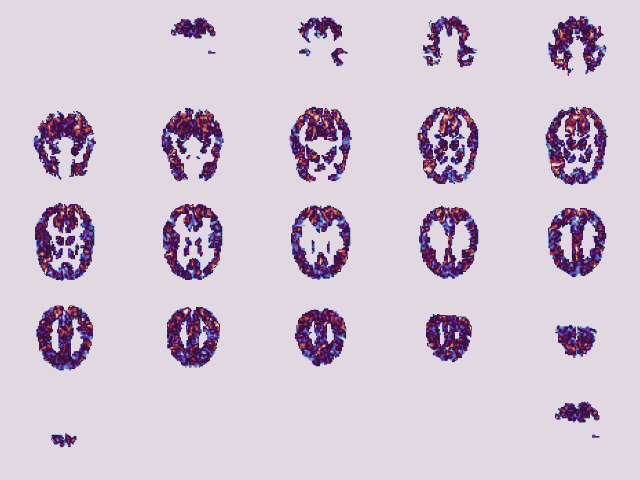

In [12]:
%matplotlib widget

def plot_scan(scan):
    scan, target = scan
    scan = (scan - scan.min()) / (scan.max() - scan.min())
    
    voxels = scan[scan != scan.min()]
    indices = np.where(scan != scan.min())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_xticks([]) or ax.set_yticks([]) or ax.set_zticks([])
    ax.set_title(target)
    ax.scatter(indices[0], indices[1], indices[2], c=voxels, alpha=voxels, cmap="twilight", s=30, marker="s")
    plt.setp(ax.spines.values(), color=(1, 1, 1))
    plt.show()

    w = 5
    fig, ax = plt.subplots(w, w, constrained_layout=True)
    fig.dpi = 100
    bg_color = (225 / 255, 216 / 255, 226 / 255)
    fig.set_facecolor(bg_color)

    for j in range(w * w):
        ax[(j - j % w) // w, j % w].imshow(scan[j % scan.shape[0]], vmin=0, vmax=1, cmap="twilight")
        ax[(j - j % w) // w, j % w].set_xticks([])
        ax[(j - j % w) // w, j % w].set_yticks([])
        plt.setp(ax[(j - j % w) // w, j % w].spines.values(), color=bg_color)

    plt.show()

plot_scan(get_sample(1))

In [8]:
def get_batch(batch_size=32, train=True):
    
    samples = list(Pool(processes=8).imap(get_sample, zip(range(batch_size), [train] * batch_size)))
    batch_x = [sample[0] for sample in samples]
    batch_y = [sample[1] for sample in samples]

    return np.array(batch_x), np.array(batch_y)

In [9]:
def layer_conv():
    return models.Sequential([
        layers.Input((64, 64 ,1)),
        layers.Conv2D(8, 16, 1, activation="tanh"),
        layers.Conv2D(8, 8, 1, activation="tanh"),
        layers.Conv2D(8, 8, 1, activation="tanh"),
        layers.Conv2D(16, 8, 1, activation="tanh"),
        layers.Conv2D(16, 8, 1, activation="tanh"),
        layers.Conv2D(16, 8, 1, activation="tanh"),
        layers.Conv2D(16, 8, 1, activation="tanh"),
        layers.Conv2D(32, 4, 1, activation="tanh"),
        layers.Conv2D(32, 2, 1, activation="tanh"),
        layers.Conv2D(64, 2, 1, activation="tanh"),
        layers.Conv2D(128, 2, 1, activation="tanh"),
        layers.Flatten()
    ])

class LayerwiseConv(Model):
    def __init__(self):
        super().__init__()
        self.convs = [layer_conv() for _ in range(23)]
        self.dense = models.Sequential([
            layers.Dense(512, activation="tanh"),
            layers.Dense(256, activation="tanh"),
            layers.Dense(128, activation="tanh"),
            layers.Dense(NUM_CLASSES, activation="softmax"),
        ])

    @tf.function(reduce_retracing=True)
    def call(self, x):
        conv_outputs = []
        for j, conv in enumerate(self.convs):
            conv_outputs.append(conv(x[:, j]))

        x = tf.convert_to_tensor(conv_outputs)
        x = tf.transpose(x, [1, 0, 2])
        x = tf.reshape(x, (-1, tf.reduce_prod(x.shape[1:])))
        x = self.dense(x)

        return x

In [10]:
BATCH_SIZE = 16

model = LayerwiseConv()

opt = optimizers.Adam()
loss = losses.MeanSquaredError()

def train():
    model.compile(opt, loss)

    for i in range(1000):
        with tf.GradientTape() as tape:
            batch_x, batch_y = get_batch(BATCH_SIZE)
            batch_x, batch_y = tf.convert_to_tensor(batch_x), tf.convert_to_tensor(batch_y)

            pred_y = model(batch_x)
            print(tf.argmax(batch_y[0]), pred_y[0], end=" ")

            if i == 0:
                model.summary()

            batchloss = loss(batch_y, pred_y)
            grad = tape.gradient(batchloss, model.trainable_variables)
            opt.apply_gradients(zip(grad, model.trainable_variables))

            print(i, float(batchloss))

        if i % 100 == 0 and i != 0:
            batch_x, batch_y = get_batch(32, train=False)
            model.evaluate(batch_x, batch_y, batch_size=1)

train()

tf.Tensor(0, shape=(), dtype=int64) tf.Tensor([0.22662586 0.218802   0.18345587 0.17180736 0.19930884], shape=(5,), dtype=float32) Model: "layerwise_conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128)               121176    
                                                                 
 sequential_1 (Sequential)   (None, 128)               121176    
                                                                 
 sequential_2 (Sequential)   (None, 128)               121176    
                                                                 
 sequential_3 (Sequential)   (None, 128)               121176    
                                                                 
 sequential_4 (Sequential)   (None, 128)               121176    
                                                                 
 sequential_5 (Sequential)   (None, 128)             

KeyboardInterrupt: 